In [1]:
import gym
import numpy as np

import time

In [2]:
import sys
import os

sys.path.append(os.path.abspath('../'))

del sys, os

In [3]:
import matplotlib.pyplot as plt

In [4]:
# LaTeX rendering in graphs
from distutils.spawn import find_executable
if find_executable('latex'):
    plt.rc('text', usetex=True)

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [5]:
import torch

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
import models.rnn as rnns
import models.mlp as mlps
import control.agents as agents
import control.environments as env

In [8]:
from utils.notifications import Slack

In [9]:
import copy

# Setup

In [29]:
model = mlps.MLP(input_dimension=4, n_hidden_layers=1, hidden_dimension=20, n_actions=2)
# model = rnns.AttentiveRNN(input_dimension=128, hidden_dimension=50, truncate=10)  #, key_dimension=15)

In [30]:
optimiser = torch.optim.Adam(model.parameters(), lr=.0001)

In [31]:
agent = agents.DQNAgent(model, optimiser, gamma=.9999, temperature=10, algorithm='expsarsa', n_actions=2)

In [33]:
environment = env.Environment(
    environment=gym.make('CartPole-v1'), 
    agent=agent,
    verbose=True,
    max_steps=1000,
    slack=Slack(),
    capacity=5000
)

In [15]:
environment.save('saved/test')

In [15]:
from utils.checkpoint import load_environment

In [16]:
load_environment('saved/test').agent.model

AttentiveRNN(
  (activation): ReLU()
  (dropout): Dropout(p=0.1)
  (input_layer): Linear(in_features=128, out_features=50, bias=True)
  (context_layer): Linear(in_features=100, out_features=50, bias=True)
  (key): Linear(in_features=50, out_features=5, bias=True)
  (query): Linear(in_features=50, out_features=5, bias=True)
  (action_layer): Linear(in_features=50, out_features=4, bias=True)
)

# Experiment

100%|###############################################################| 10/10 [02:00<00:00, 11.84s/it]


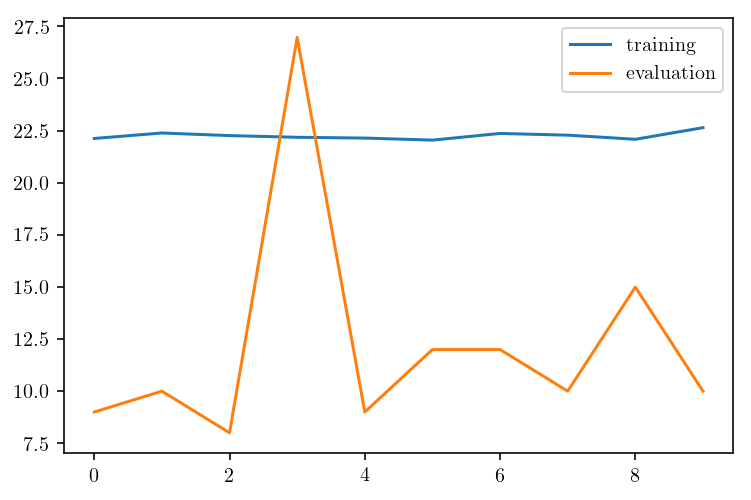

100%|###############################################################| 10/10 [02:09<00:00, 12.71s/it]


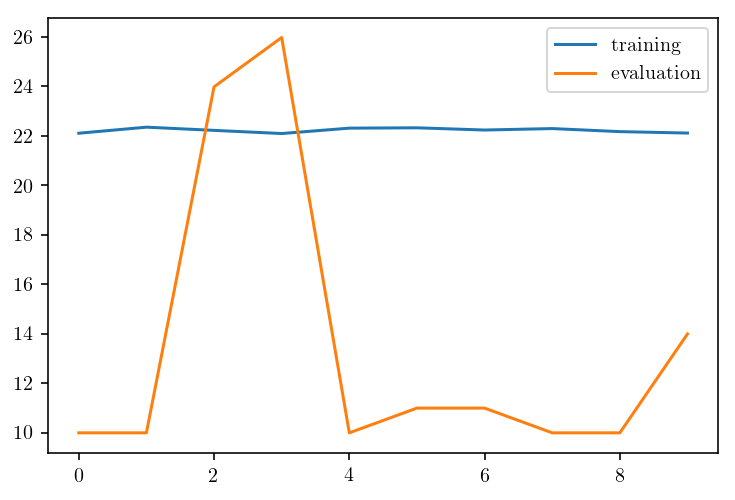

100%|###############################################################| 10/10 [02:03<00:00, 12.21s/it]


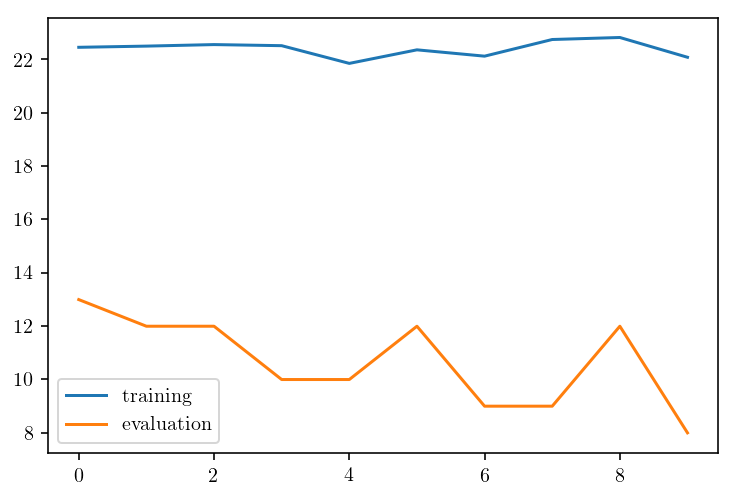

100%|###############################################################| 10/10 [01:59<00:00, 12.05s/it]


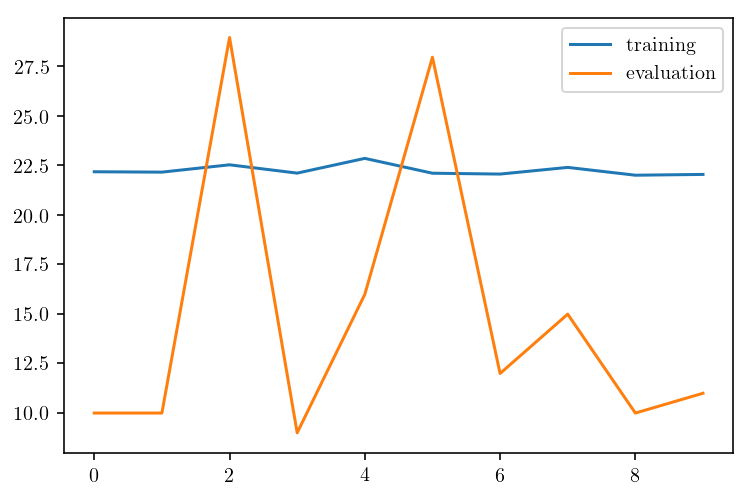

100%|###############################################################| 10/10 [02:13<00:00, 13.22s/it]


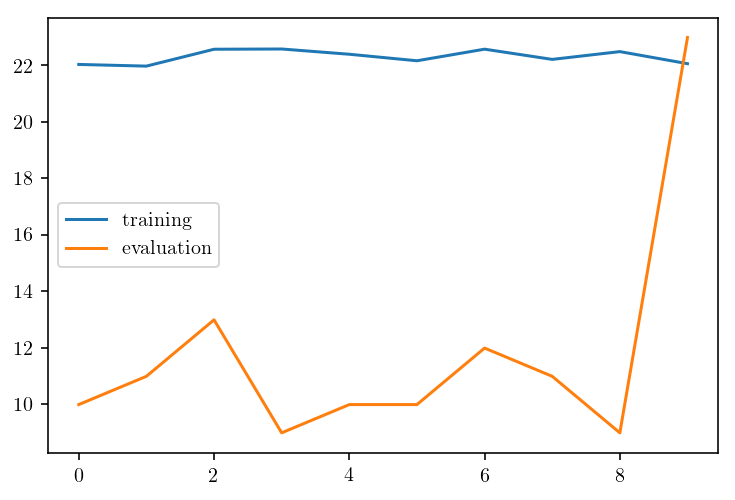

100%|###############################################################| 10/10 [01:51<00:00, 10.87s/it]


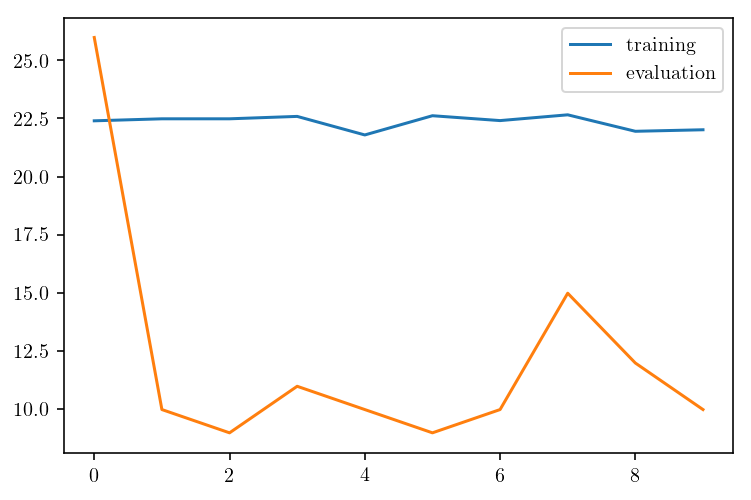

100%|###############################################################| 10/10 [01:47<00:00, 10.81s/it]


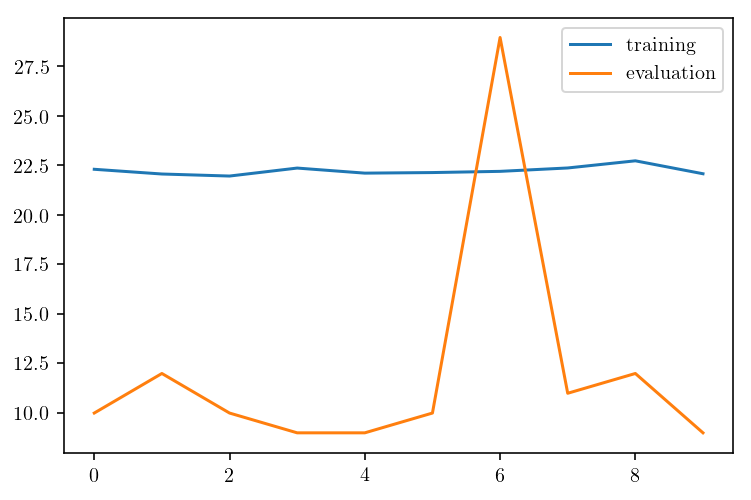

100%|###############################################################| 10/10 [01:48<00:00, 10.86s/it]


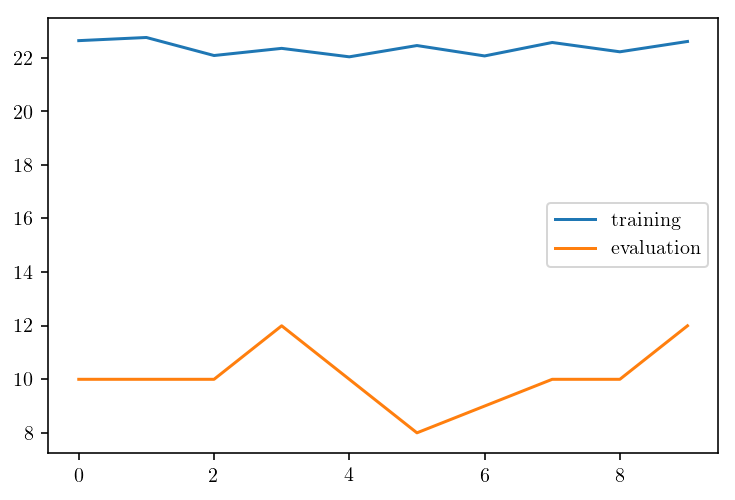

100%|###############################################################| 10/10 [01:48<00:00, 10.98s/it]


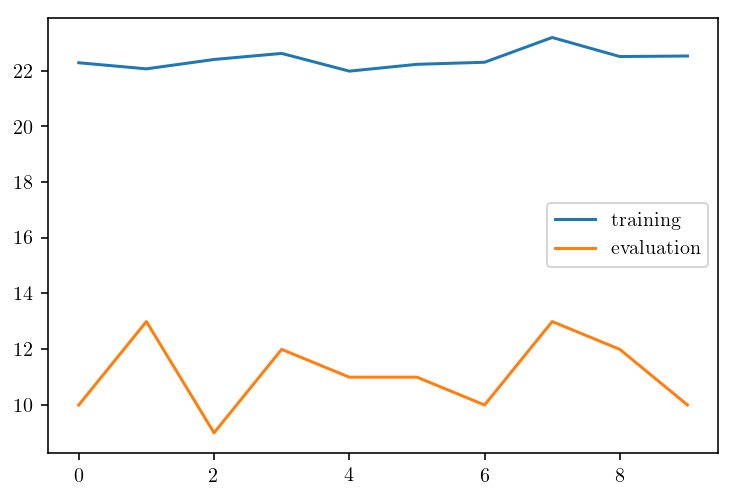

100%|###############################################################| 10/10 [01:51<00:00, 11.03s/it]


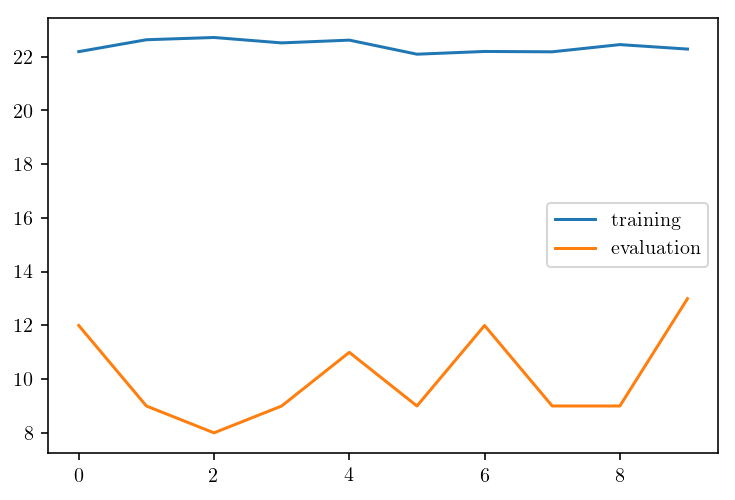

In [34]:
for _ in range(10):
    
    returns = environment.train(segments=10, episodes=2000)

    plt.figure()
    plt.plot(returns.T[0], label='training')
    plt.plot(returns.T[1], label='evaluation')
    plt.legend()
    plt.show()
    
    agent.temperature *= .8

100%|###############################################################| 10/10 [02:27<00:00, 13.89s/it]


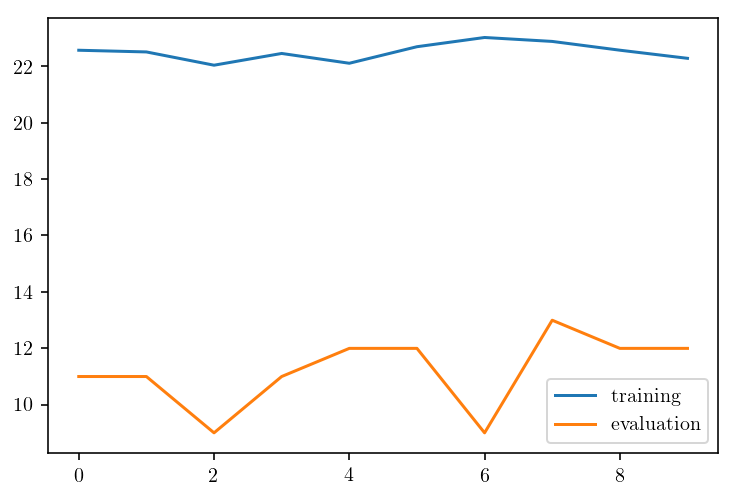

100%|###############################################################| 10/10 [02:26<00:00, 15.53s/it]


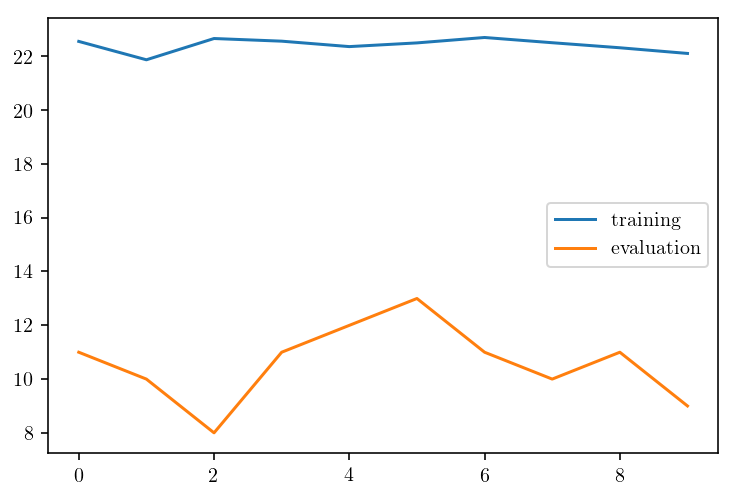

100%|###############################################################| 10/10 [02:10<00:00, 12.73s/it]


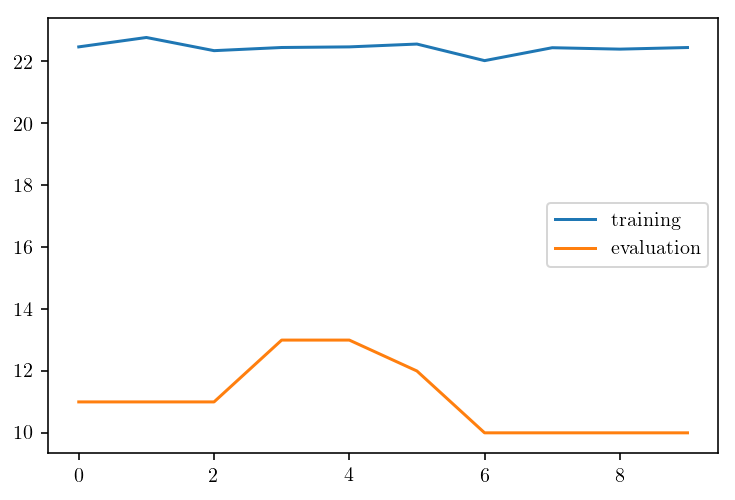

100%|###############################################################| 10/10 [02:14<00:00, 13.43s/it]


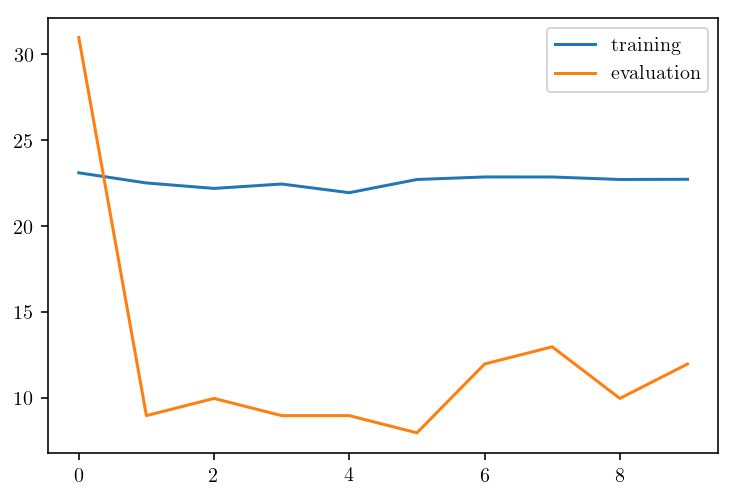

100%|###############################################################| 10/10 [02:23<00:00, 13.58s/it]


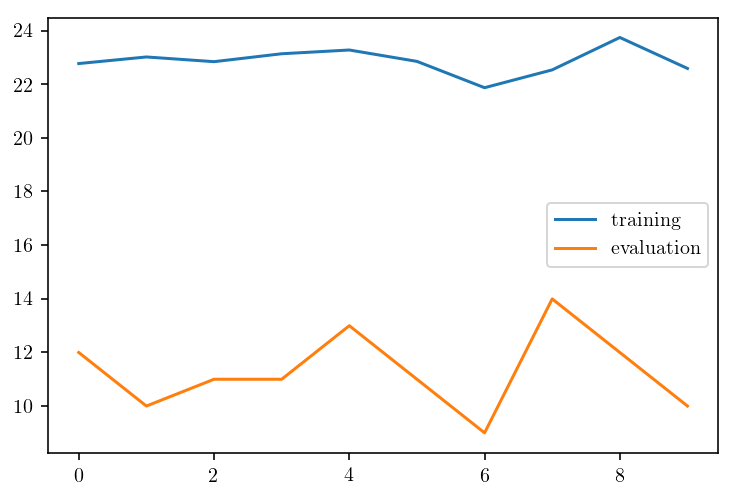

100%|###############################################################| 10/10 [02:50<00:00, 16.86s/it]


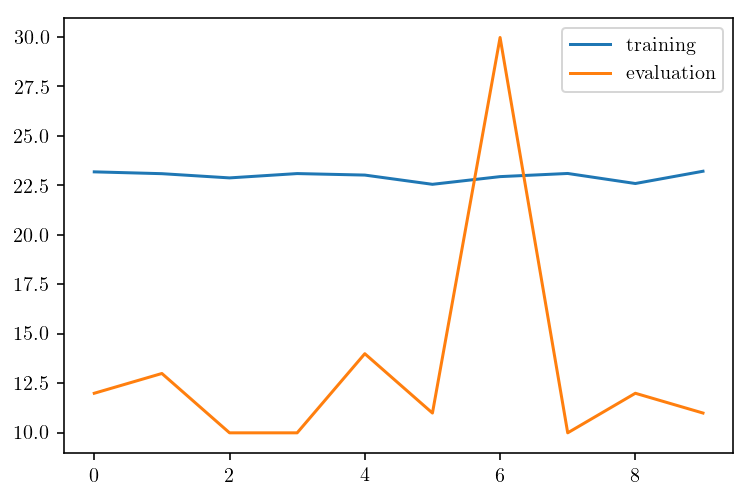

 30%|###################2                                            | 3/10 [01:01<02:27, 21.08s/it]

In [ ]:
for _ in range(10):
    
    returns = environment.train(segments=10, episodes=2000)

    plt.figure()
    plt.plot(returns.T[0], label='training')
    plt.plot(returns.T[1], label='evaluation')
    plt.legend()
    plt.show()
    
    agent.temperature *= .8

In [ ]:
agent.temperature

In [83]:
environment.exploration_segment(20)

(25.959265773117163, 8.996400839874012)

In [79]:
environment.batch(100)

In [37]:
environment.reset()
s = environment.state

In [38]:
agent.q(s)

array([-0.06783922, -0.04041   , -0.04206257, -0.1287726 ], dtype=float32)

In [123]:
agent.commit()

In [124]:
agent.q(x)

array([-0.7905634 , -0.24595691, -0.15114474, -0.5289955 ], dtype=float32)

In [31]:
environment.evaluation_episode()

(0.0, 1000)

In [1750]:
state = environment.environment.reset()

agent.eval()

done = False
full_return = 0.

action = np.random.choice(environment.greedy(state))

counter = 0
while not done and counter < 10000:
    
    s, reward, done, i = environment.environment.step(action)

    # If there are ties, we might want to choose between actions at random
    a = np.random.choice(environment.greedy(s))

    # We store the new state and action
    state, action = s, a
    
    full_return = agent.gamma * full_return + reward
    counter += 1

full_return, counter

(0.0, 160)

In [1515]:
state = environment.environment.reset()
action = np.random.choice(environment.greedy(state))

In [1784]:
s, reward, done, i = environment.environment.step(action)

# If there are ties, we might want to choose between actions at random
# a = np.random.choice(4, p=environment.epsilon_greedy(s, .1))
a = environment.environment.action_space.sample()

# We store the new state and action
state, action = s, a

done = done or i['ale.lives'] < 5

done, i, a

(True, {'ale.lives': 4}, 0)

# Training

In [1752]:
environment.run(epochs=2, segments=5, episodes=50)

100%|#################################################################| 5/5 [00:45<00:00,  9.41s/it]


In [23]:
environment.save('../saved/')